## Bearing Fault Classification using Deep Reinforcement Learning

    Reference Paper: Intelligent fault diagnosis for rotating machinery using deep Q-network
                     based health state classification: A deep reinforcement learning approach by:
                     Yu Ding, Liang Ma, Jian Ma, Mingliang Suo, Laifa Tao, Yujie Cheng, Chen Lu
    
    Data: Case Western Bearing Data
          https://engineering.case.edu/bearingdatacenter/download-data-file

### Description

    1. In this project, bearing fault classification is done with the help of Deep Q Learning method.
    2. A Deep Reinforcement Learning Agent is used to predict whether vibration data of a bearing state is in
       which fualt mode.
    3. The deep reinforcement learning agent has a 2 Convolution Layer with 2 Fully connected layers and a output 
       layer to predict q-values.
    4. Vibration data is converted to 2D Continous Wavelet Transform Scalogram for the Training and Testing the               agent.
    5. The training takes place as quiz game where the agent will predict N number of scalograms in an episode. 
       The scalograms in an episode contains Bearing state of 4 different conditions.
    6. If the agent predicts correctly, then it gets a reward of +1 else -1.
    7. The goal of the agent is to maximize rewards, thus the goal is to train the agent to predict the state of 
       the scalogram.

### Import Libraries

In [1]:
import torch                              # Torch
import matplotlib.pyplot as plt           # Plotting
import numpy as np                        # Numpy
from collections import deque, namedtuple # Special List and Tuple
import torch.nn as nn                     # Neural Networks
import torch.nn.functional as F           # Functional API
import torch.optim as optim               # Optimizers
from torchsummary import summary          # Summarizer
import random                             # Random
import os                                 # To handle files

### Implement Q Network

In [2]:
class QNetwork(nn.Module):
    '''Q-Network'''
    def __init__(self, ch_size, action_size, seed, cnn_1, cnn_2, unit_1, unit_2, kernel_size=3, stride=2, pool_size=2):
        '''Construct the Q-Network:
           Parameters:
           ===========
                      ch_size     : The size of the channels in an image;     ===> Type: Integer.
                      action_size : The number of actions;                    ===> Type: Integer.
                      seed        : To Seed;                                  ===> Type: Integer.
                      cnn_1       : The number of filters in CNN Layer 1;     ===> Type: Integer.
                      cnn_2       : The number of filters in CNN Layer 2;     ===> Type: Integer.
                      units_1     : The number of units in Dense Layer 1;     ===> Type: Integer.
                      units_2     : The number of units in Dense Layer 2;     ===> Type: Integer.
                      kernel_size : The size of kernel in Convolution;        ===> Type: Integer.
                      stride      : The strides in Convolution;               ===> Type: Integer.
                      pool_size   : The pooling kernel size;                  ===> Type: Integer.
        '''
        super(QNetwork, self).__init__()
        self.seed  = torch.manual_seed(seed)   # Seed Torch
        self.cnn_layer_1  = nn.Conv2d(in_channels=ch_size, out_channels=cnn_1, kernel_size=kernel_size, stride=stride) # CNN Layer 1
        self.pool_layer_1 = nn.MaxPool2d(kernel_size=pool_size, stride=1)            # Max Pool Layer 1
        self.cnn_layer_2  = nn.Conv2d(in_channels=cnn_1, out_channels=cnn_2, kernel_size=kernel_size, stride=stride) # CNN Layer 2
        self.pool_layer_2 = nn.MaxPool2d(kernel_size=pool_size, stride=1)            # Max Pool Layer 2
        self.dense_1      = nn.Linear(in_features=cnn_2*13*13, out_features=unit_1)  # Dense Layer 1
        self.dense_2      = nn.Linear(in_features=unit_1, out_features=unit_2)       # Dense Layer 2
        self.dense_3      = nn.Linear(in_features=unit_2, out_features=action_size)  # Dense Layer 3

    def forward(self, state):
        '''Makes a Forward Pass of the Neural Network.
           Parameters:
           ===========
                      state: The state of the environment i.e. here an image; ===> Type: 3D-Tensor; Size: (3X64x64).
           Return:
           ===========
                      x: The action values; Type ===> Tensor; Size: action_size.
        '''
        x = F.relu(self.cnn_layer_1(state)) # CNN Layer gets Relu Activation
        x = self.pool_layer_1(x)            # Pool
        x = F.relu(self.cnn_layer_2(x))     # CNN Layer gets Relu Activation
        x = self.pool_layer_2(x)            # Pool
        x = torch.flatten(x, 1)             # Flatten
        x = F.relu(self.dense_1(x))         # Dense Layer gets Relu Activation
        x = F.relu(self.dense_2(x))         # Dense Layer fets Relu Activation
        x = self.dense_3(x)                 # Output Dense Layer
        
        return x

### Summarize the Network with Dummy Values

In [3]:
q = QNetwork(3, 4, 2, 64, 32, 64, 32, 3, 2, 2) # Create Q network
input_shape = (3,64,64) # Input Shape of Image
print(summary(q, input_shape)) # Summarize

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 31, 31]          1,792
├─MaxPool2d: 1-2                         [-1, 64, 30, 30]          --
├─Conv2d: 1-3                            [-1, 32, 14, 14]          18,464
├─MaxPool2d: 1-4                         [-1, 32, 13, 13]          --
├─Linear: 1-5                            [-1, 64]                  346,176
├─Linear: 1-6                            [-1, 32]                  2,080
├─Linear: 1-7                            [-1, 4]                   132
Total params: 368,644
Trainable params: 368,644
Non-trainable params: 0
Total mult-adds (M): 5.62
Input size (MB): 0.05
Forward/backward pass size (MB): 0.52
Params size (MB): 1.41
Estimated Total Size (MB): 1.97
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 31, 31]          1,792
├─MaxPool2d: 1-2                         [-1, 64, 30, 30] 

### Replay Buffer

In [4]:
class ReplayBuffer:
    '''Stores Experiences in Buffer'''
    def __init__(self, action_size, buffer_size, seed, batch_size):
        '''Constructs the Replay Buffer.
           Parameters:
           ===========
                      action_size : The number of actions; ===> Type: Integer.
                      buffer_size : The buffer dimensions; ===> Type: Integer.
                      seed        : To seed;               ===> Type: Integer.
                      batch_size  : The batch size;        ===> Type: Integer.
        '''
        self.action_size = action_size               # Action Size
        self.batch_size  = batch_size                # Batch Size
        self.memory      = deque(maxlen=buffer_size) # Special List
        self.experiences = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done']) # Special Dictionary
        self.seed        = random.seed(seed)         # Seed
        
    def add(self, state, action, reward, next_state, done):
        '''Adds Experiences to the Memory.
           Parameters:
           ===========
                      state  :  The state i.e. here an image;       ===> Type: 2D Tensor; Size: (3x64x64).
                      action : The Action taken in that state;      ===> Type: Integer.
                      reward : The reward obtained from the action; ===> Type: Integer.
                      state  :  The next state i.e. here an image;  ===> Type: 2D Tensor; Size: (3x64x64).
                      done   :   If the task in completed ot not;   ===> Type: Bool.
           Return:
           ===========
                      None.
        ''' 
        e = self.experiences(state, action, reward, next_state, done) # Add Experience 
        self.memory.append(e) # Append To Memory
        
    def __len__(self):
        '''Returns the current size of memory.
           Parameters:
           ===========
                      None.
           Return:
           ===========
                      Length of memory; ===> Type: Integer.
        '''
        return len(self.memory) # Return.
    
    def sample(self):
        '''Sample Experiences from Memory.
           Parameters:
           ===========
                      None.
           Return:
           ===========
                      Tuple of (state, action, reward, next_state, done); ===> Type: Tuple.
        '''
        experiences = random.sample(self.memory, k=self.batch_size) # Sample from Memory
        states      = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)   # State Tensor.
        actions     = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)   # Action Tensor.
        rewards     = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)  # Reward Tensor.
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)            # Next States Tensor.
        dones       = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device) # Dones Tensor.
        
        return (states, actions, rewards, next_states, dones) # Return tuple of tensors.

### Define Agent

In [18]:
class Agent:
    '''Interacts with the Environment and Learns from Experiences.'''
    def __init__(self, action_size, seed):
        '''Constructs the Agent.
           Parameters:
           ===========
                      action_size : The action-space dimension; ===> Type: Integer.
                      seed        : The random seed;            ===> Type: Integer.
        '''
        self.action_size = action_size         # Action Size
        self.seed        = random.seed(seed)   # Seed
         
        # Deep-Q-Network
        self.qnet_local  = QNetwork(ch_size=3, action_size=action_size, seed=seed, cnn_1=64, cnn_2=32, unit_1=64, unit_2=32).to(device) # Local Q Network
        self.qnet_target = QNetwork(ch_size=3, action_size=action_size, seed=seed, cnn_1=64, cnn_2=32, unit_1=64, unit_2=32).to(device) # Target Q Network
        self.optimizer   = optim.Adam(self.qnet_local.parameters(), lr=LR) # Optimizer Adam
        
        # Replay Memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, seed, BATCH_SIZE) # Replay Memory
        self.t_step = 0 # Time Step to update every x iterations
        
    def step(self, state, action, reward, next_state, done):
        '''Saves Experiences in Memory and Learns from experiences.
           Parameters:
           ===========
                      state      : The state i.e. here an image;        ===> Type: 3D Tensor; Size: (3x64x64).
                      action     : The Action taken in that state;      ===> Type: Integer.
                      reward     : The reward obtained from the action; ===> Type: Integer.
                      next_state : The next state i.e. here an image;   ===> Type: 3D Tensor; Size: (3x64x64).
                      done       : If the task in completed ot not;     ===> Type: Bool.
           Return:
           ===========
                      None.
        '''
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # State Tensor - Convert to 4D
        next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device) # State Tensor - Convert to 4D
        self.memory.add(state, action, reward, next_state, done) # Add Experiences to Memory

        # Learn EVERY UPDATE Steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY # Get Remainder
        
        if self.t_step == 0:                           # When Remainder is 0
            if len(self.memory) > BATCH_SIZE:          # If enough experiences are there in the memory, then learn
                experiences = self.memory.sample()     # Samples Experiences
                self.learn(experiences, GAMMA)         # Learn
    
    def action(self, state, eps=0.0):
        '''Returns actions as per current policy.
           Parameters:
           ===========
                      state :  The state i.e. here an image; ===> Type: 3D Tensor; Size: (3x64x64).
                      eps   :  Epsilon-greedy parameter;     ===> Type: Float.
           Return:
           ===========
                      Action to take; ===> Type: Integer.
        '''
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # State Tensor - Convert to 4D
        
        # Get Actions
        self.qnet_local.eval()   # Evaluation Mode
        with torch.no_grad():
            action_values = self.qnet_local(state) # Get action Values
            
        self.qnet_local.train()  # Train Mode
        
        # Epsilon-Greedy Action Selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy()) # Greedy Action.
        else: 
            return random.choice(np.arange(self.action_size))  # Random Action.
        
    def learn(self, experiences, gamma):
        '''Learns from experiences by updating the network.
           Parameters:
           ===========
                      experiences : Experiences of state, action, reward, next state and done; ===> Type: Tuple.
                      gamma       : Discount factor;                                           ===>  Type: Float.
           Return:
           ===========
                      None.
        '''
        states, actions, rewards, next_states, dones = experiences # Extract Tensors

        # Get Maximum predicted Q-Values from Target Network.
        Q_targets_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1) # Actions
        
        # Compute Q-Targets for current states.
        Q_targets = rewards + (gamma*Q_targets_next*(1-dones))
        
        # Get expected Q values from Local Network.
        Q_expected = self.qnet_local(states).gather(1, actions)
        
        # Compute Loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize The Loss by Back Propagation of Q-Net Local
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update Target Network
        self.soft_update(self.qnet_local, self.qnet_target, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Paramaters:
        ===========
                   local_model  : Q Network Local where weights will be copied from; ===> Type: Object
                   target_model : Q Network Target where weights will be copied to;  ===> Type: Object
                   tau          : Interpolation parameter;                           ===> Type: Float
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    @staticmethod
    def test_agent(qnet, image, image_name):
        '''Tests the trained agent.
           Parameters:
           ===========
                      qnet       : The trained neural network; ===> Type: Object.
                      image      : The Test image;             ===> Type: String.
                      image_name : The name of image file;     ===> Type: String.
           Return:
           ===========
                      None.
        '''
        image_t = torch.from_numpy(image).float().unsqueeze(0).to(device) # To 4-D Tensor
        action = qnet(image_t)  # Get Action values
        fault_pred = np.argmax(action.cpu().data.numpy()) # Get maximum of the action values
        
        # Print Real Result
        if int(image_name[0]) == 0:
            print('Real State: Normal')
        elif int(image_name[0]) == 1:
            print('Real State: Inner Race Fault')
        elif int(image_name[0]) == 2:
            print('Real State: Ball Fault')
        elif int(image_name[0]) == 3:
            print('Real State: Outer Race Fault')
        
        # Print Predicted Result
        if fault_pred == 0:
            print(f'Predicted Fault: Normal State') # Print
        elif fault_pred == 1:
            print(f'Predicted Fault: Inner Race Fault') # Print
        elif fault_pred == 2:
            print(f'Predicted Fault: Ball Fault') # Print
        elif fault_pred == 3:
            print(f'Predicted Fault: Outer Race Fault') # Print
            
        # Plot Scalogram
        plt.figure(figsize=(6,6))
        plt.imshow(image.reshape((64,64,3)), cmap=plt.cm.jet)
        plt.title('Scalogram')
        plt.axis('off')
        plt.show()
    
    @staticmethod
    def test(qnet, test_dir):
        '''Tests the trained agent.
           Parameters:
           ===========
                      qnet       : The trained neural network; ===> Type: Object.
                      test_dir   : The Test directory;         ===> Type: String. 
           Return:
           ===========
                      None.
        '''
        test_image_list = os.listdir(test_dir) # Get List of Test Images
        score = 0                              # Score
        for i in range(len(test_image_list)):
            image = plt.imread(test_dir + test_image_list[i])                  # Read Image
            image = image.reshape((3,64,64))                                   # Reshape Images
            fault = test_image_list[i][0]                                      # Read Image Fault
            image_t = torch.from_numpy(image).float().unsqueeze(0).to(device)  # To 4-D Tensor
            action = qnet(image_t)                                             # Get Action
            fault_pred = np.argmax(action.cpu().data.numpy())                  # Get maximum of the action values
            
            if int(fault) == fault_pred:
                score = score + 1                # Correct Answer get +1 Score
        
        print("Total Images in Test Set: ", len(test_image_list), 'Images')                       # Total Data set 
        print("Highest Score that can be obtained: ", len(test_image_list))                       # Highest Score
        print("Score Obtained with trained agent: ", score)                                       # Score
        print("Accuracy of Agent: ", np.around(score/len(test_image_list), decimals=2)*100, ' %') # Accuracy
                

### Define Parameters

In [6]:
BUFFER_SIZE  = int(1e6)  # Size of Buffer.
BATCH_SIZE   = 32        # Batch size to sample Experiences.
GAMMA        = 0.99      # Discount Factor.
TAU          = 1e-03     # Soft Update Parameter.
LR           = 5e-04     # Learning Rate.
UPDATE_EVERY = 4         # Update every __ number of steps.

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Device
print('Device:', device) # Print Device

Device: cpu


### Environment

In [8]:
class Environment:
    '''The Environment of the Model'''
    def __init__(self, directory_data, num_folders, train, test):
        '''Constructs the Environment.
           Parameters:
           ===========
                      directory_data : The name of directory;              ===> Type: String.
                      num_folders    : The number of folders for training; ===> Type: Integer.
                      train          : The name of Training batch folders; ===> Type: String
                      test           : The name of Testing directory;      ===> Type: String.
        '''
        self.dir = directory_data # Directory name
        self.num = num_folders    # Number of Folders
        self.train = train        # Training folder
        self.test = test          # Testing Folder
        self.list_images =[]      # List of names of images in folder
        self.directory = None     # Directory name with Data + Batch_n
        
    def step(self, state, action, real_class, i_state):
        '''Takes Action on a State, gets next state, rewards and if game is over or not.
           Parameters:
           ===========
                      state      : The current state i.e. here an image; ===> Type: 3D Tensor; Size: (3x64x64). 
                      action     : The action taken by the agent;        ===> Type: Integer.
                      real_class : The class of fault the state belongs; ===> Type: Integer.
                      i_state    : The index of current state;           ===> Type: Integer.
           Return:
           ===========
                      reward     : The reward obtained from the action; ===> Type: Integer.
                      next_state : The next state i.e. here an image;   ===> Type: 3D Tensor; Size: (3x64x64).
                      done       : If the task in completed ot not;     ===> Type: Bool.
                      real_class_next_state: The class of fault the state belongs; ===> Type: Integer.
        '''
        # Decide Reward
        if int(action) == int(real_class):    # If agent predicts right action
            reward = 1 
        else:
            reward = -1
            
        # Get Next State
        if i_state < len(self.list_images) -1:                       # When there are images in the batch
            next_state_name = self.list_images[i_state+1]            # Get  Next State Name i.e. Image names
            real_class_next_state = int(next_state_name[0])          # Get class of fault the image belongs to 
            next_state = plt.imread(self.directory+next_state_name)  # Get State
            next_state = next_state.reshape((3,64,64))               # Reshape Image
            done = False                                             # Game is not over
            
        else:  # When there are no images in the batch
            done = True                    # Game is over
            next_state = None              # There is no next state
            real_class_next_state = None   # There are no faults
            
        return reward, next_state, done, real_class_next_state # Return
        
    def get_num_images(self, i_episode):
        '''Gives the Number of images in the Episode/Batch.
           Parameters:
           ===========
                      i_episode: The episode/batch number; ===> Type: Integer.
           Return:
           ===========
                      episode_img : The number of images in the natch;         ===> Type: Integer
                      list_images : The list of image names which are shuffled ===> Type: List.
                      directory   : The directory name;                        ===> Type: String.
        '''
        episode_img = len(os.listdir(self.dir + self.train + f'_{i_episode+1}/')) # Get the number of images
        list_images = os.listdir(self.dir + self.train + f'_{i_episode+1}/')      # Get Names of Images
        random.shuffle(list_images)                                               # Shuffle Images
        directory = self.dir + self.train + f'_{i_episode+1}/'                    # Directory name
        
        self.list_images = list_images  # Update List
        self.directory = directory      # Directory name with Data + Batch_n
        
        return episode_img, list_images, directory  # Return

### Define Environment

### DQN Fault Classification

In [11]:
def DQN_Fault_Classification(n_episodes=1700, eps_start=1.0, eps_end=0.075, eps_decay=0.995):
    '''Trains Agent to Classify Faults.
       Parameters:
       ===========
                  n_episodes : The maximum number of training episodes; ===> Type: Integer.
                  eps_start  : Starting value of epsilon;               ===> Type: Float.
                  eps_end    : Ending value of epsilon ;                ===> Type: Float.
                  eps_decay  : Decaying factor of epsilon;              ===> Type: Float.
       Return:
       ===========
                  scores: Score obtained in each episode; ===> Type: List.
    '''
    scores        = []                # Scores List 
    scores_window = deque(maxlen=100) # Score Windows to store last 100 scores
    eps           = eps_start         # Epsilon Greedy
    
    # Objects of Agent and Environment 
    agent = Agent(action_size=4, seed=6)  # Agent
    env   = Environment(directory_data='Data/', num_folders=n_episodes, train='Batch', test='test') # Environment
    
    # Train
    for i_episode in range(n_episodes):
        score = 0                                                           # Initialise Score to zero
        EPISODE_IMG, list_images, directory = env.get_num_images(i_episode) # Get Episode Details
        
        # Get states of the first image in the list
        state_name = list_images[0]                                         # Get State Name i.e. Image names
        real_class = int(state_name[0])                                     # Get class of fault the image belongs to 
        state = plt.imread(directory+state_name)                            # Get State
        state = state.reshape((3,64,64))                                    # Reshape Image

        for i_state in range(EPISODE_IMG): 

            action = agent.action(state)                                                        # Get Action for the state
            reward, next_state, done, real_class = env.step(state, action, real_class, i_state) # Pass Action to get rewards and next state
            if next_state is not None:
                agent.step(state, action, reward, next_state, done)         # Learn from experience
            state = next_state                                          # Update State
            score = score + reward                                      # Update Score

        
        scores_window.append(score)        # Append to List
        scores.append(score)               # Append to list
        eps = max(eps_end, eps_decay*eps)  # Decay Epsilon Values
        
        # Print Scores
        if i_episode % 10 == 0:                                                          # Print Every 100 Episodes
            print(f'Episode: {i_episode} =====> Average Score: {np.mean(scores_window)}') # Print 
    
        if np.mean(scores_window) >=35:                                                  # If Score average is x plus      
            torch.save(agent.qnet_local.state_dict(), 'DQN_FC.pth')                       # Save Weights.
            print(f'\nEnvironment solved in {i_episode-100} episodes! =====> Average Score: {np.mean(scores_window)}') # Print.
            
        if i_episode == n_episodes-1:                              # If Last Episode
            torch.save(agent.qnet_local.state_dict(),'DQN_FC.pth') # Save Weights.
            
    return scores # Return Scores
          

### Train the agent

In [ ]:
scores = DQN_Fault_Classification(n_episodes=1700, eps_start=1.0, eps_end=0.075, eps_decay=0.995)

Episode: 0 =====> Average Score: -30.0
Episode: 10 =====> Average Score: -30.0
Episode: 20 =====> Average Score: -29.904761904761905
Episode: 30 =====> Average Score: -28.967741935483872
Episode: 40 =====> Average Score: -27.170731707317074
Episode: 50 =====> Average Score: -25.96078431372549
Episode: 60 =====> Average Score: -24.0
Episode: 70 =====> Average Score: -22.169014084507044
Episode: 80 =====> Average Score: -20.641975308641975
Episode: 90 =====> Average Score: -19.626373626373628
Episode: 100 =====> Average Score: -18.0
Episode: 110 =====> Average Score: -15.6
Episode: 120 =====> Average Score: -12.96
Episode: 130 =====> Average Score: -10.96
Episode: 140 =====> Average Score: -9.6
Episode: 150 =====> Average Score: -7.78
Episode: 160 =====> Average Score: -6.88
Episode: 170 =====> Average Score: -6.06
Episode: 180 =====> Average Score: -5.52
Episode: 190 =====> Average Score: -4.48
Episode: 200 =====> Average Score: -4.58
Episode: 210 =====> Average Score: -4.28
Episode: 22

### Load Saved Model

In [6]:
qnet = QNetwork(ch_size=3, action_size=4, seed=6, cnn_1=64, cnn_2=32, unit_1=64, unit_2=32) # Model
qnet.load_state_dict(torch.load('DQN_FC.pth')) # Load Model
qnet.eval() # Evaluation Mode

QNetwork(
  (cnn_layer_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (pool_layer_1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn_layer_2): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (pool_layer_2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dense_1): Linear(in_features=5408, out_features=64, bias=True)
  (dense_2): Linear(in_features=64, out_features=32, bias=True)
  (dense_3): Linear(in_features=32, out_features=4, bias=True)
)

### Get Test Data Images

In [7]:
test_dir = 'Data/Test/' # Test Data Directory
test_list = os.listdir(test_dir) # Test Image Names

### Normal Condition

Real State: Normal
Predicted Fault: Normal State


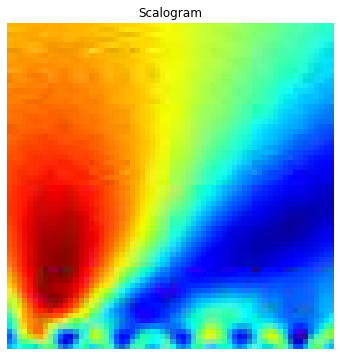

In [8]:
image = plt.imread(test_dir + test_list[0]) # Read  Image
image = image.reshape((3,64,64))            # Reshape Image
Agent.test_agent(qnet, image, test_list[0]) # Test Agent

### Inner Race Fault

Real State: Inner Race Fault
Predicted Fault: Outer Race Fault


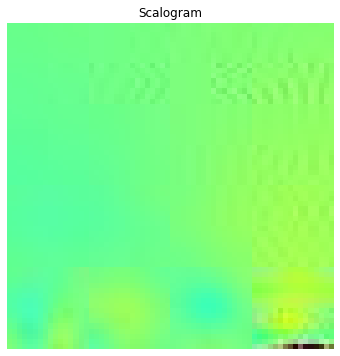

In [9]:
image = plt.imread(test_dir + test_list[9]) # Read  Image
image = image.reshape((3,64,64))            # Reshape Image
Agent.test_agent(qnet, image, test_list[9]) # Test Agent

### Ball Fault

Real State: Ball Fault
Predicted Fault: Ball Fault


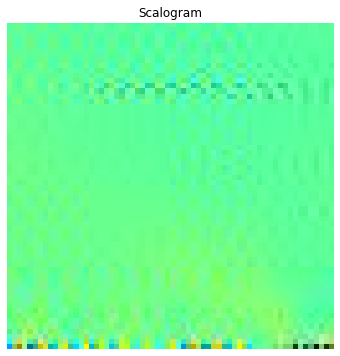

In [10]:
image = plt.imread(test_dir + test_list[4000]) # Read  Image
image = image.reshape((3,64,64))              # Reshape Image
Agent.test_agent(qnet, image, test_list[4000]) # Test Agent

### Outer Race Fault

Real State: Outer Race Fault
Predicted Fault: Outer Race Fault


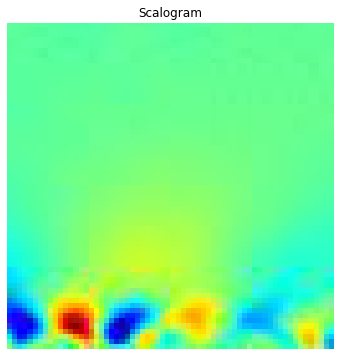

In [11]:
image = plt.imread(test_dir + test_list[3900]) # Read  Image
image = image.reshape((3,64,64))              # Reshape Image
Agent.test_agent(qnet, image, test_list[3900]) # Test Agent

### Accuracy of Agent

In [19]:
Agent.test(qnet, test_dir) # Test Accuracy on unseen data

Total Images in Test Set:  21657 Images
Highest Score that can be obtained:  21657
Score Obtained with trained agent:  20082
Accuracy of Agent:  93.0  %
